# Usando SVD para comprimir imagens
> SVD Compression
- toc: true 
- badges: true
- comments: true
- author: Victor Nascimento
- categories: [jupyter]
- image: images/chart-preview.png

Uma aplicação muito interessante da Decomposição em Valores Singuladores, mais conhecida pela sua sigla SVD (Singular Values Decomposition) é a de conseguir criar uma aproximação da matrix original, mas usando menos informações. Isso fica mais claro na prática. Suponha que temos a seguinte matrix:

É claro que as colunas são linearmente dependentes. Portanto não precisamos guarda os 50 números que compõe essa matriz. É muito mais eficiente salvar vetores que resultam nela. Aplicando SVD temos:

Vamos ver agora como essa mesma ideia pode ser usada para comprimir imagens.

In [1]:
#collapse
import matplotlib.image as img
from skimage import color
import matplotlib.pyplot as plt
import numpy as np
from math import log

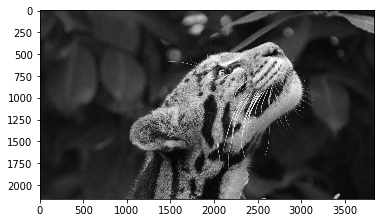

In [2]:
#collapse
img = img.imread('D:\Downloads\svd1.jpeg')
image = color.rgb2gray(img)
m, n = image.shape
plt.imshow(image, cmap=plt.get_cmap('gray'))
plt.show()
u, s, vt = np.linalg.svd(image)

Temos aqui uma imagem com 2160 pixels de largura e 3840 pixels de comprimento. Cada pixel é um número. Essa imagem pode ser expressa por uma matriz onde cada número é a cor de um pixel. Como é uma imagem preto e branco, temos uma matriz com 2160 linhas e 3840 colunas, ou seja, ela tem 8.294.400 bytes!

In [3]:
#hide_input
print(image)

[[0.12413059 0.13197373 0.12805216 ... 0.09780275 0.10564588 0.10956745]
 [0.12020902 0.12805216 0.12805216 ... 0.10564588 0.10956745 0.11348902]
 [0.11628745 0.12413059 0.12805216 ... 0.10564588 0.10956745 0.10956745]
 ...
 [0.10564588 0.12133216 0.12917529 ... 0.05072824 0.05072824 0.06249294]
 [0.11741059 0.12133216 0.12525373 ... 0.05072824 0.0546498  0.06641451]
 [0.12133216 0.12133216 0.12525373 ... 0.05857137 0.06249294 0.07033608]]


A questão é: realmente precisamos de todos esses números? Usando a decomposição singular fica claro que a resposta é não. Podemos encontrar uma ótima aproximação para essa matriz. Primeiro vamos ver como seus valores singulares se comportam. 

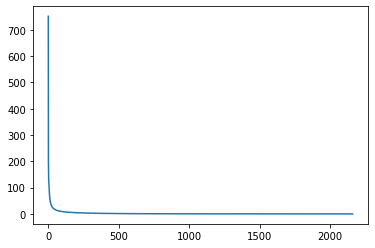

In [4]:
#gráfico dos valores singulares
plt.plot(np.arange(2160),s)
plt.show()

Fica evidente o quão rápido decrescem, portanto vamos colocar em uma escala logarítimica.

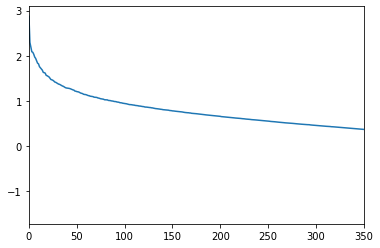

In [5]:
#gráfico dos valores singulares
s_log = [log(y,10) for y in s]
plt.plot(np.arange(2160),s_log)
plt.xlim(0,350)
plt.show()

Dessa forma surge a questão: Quantos valores singulares queremos para que tenhamos uma boa aproximação da matriz original? Para isso usamos a regrão do dedão que consiste em manter pelo menos 80 ou 90% da soma dos quadrados dos valores singulares originais. Isso pode ser dado pela seguinte equação: 

<img src='dedao.png' width="220" height="220">

Podemos então fazer um função para que recebe os valores singulares como parâmetros e retorna a posição do último que obedece a regra do dedão.

In [6]:
#escolhendo k
def escolheK(s):
    """ Retorna o menor k tal que a soma dos quadrados dos k primeiros elementos do array s é >= 90%
        da soma dos quadrados dos elementos de s.
    
        Entrada:
            s é um vetor contendo os valores singulares em ordem decrescente
    """
    k = 0
    t = 0
    m, n = s.reshape((-1,1)).shape
    total = s.reshape((-1,1)).T @ s.reshape((-1,1))
    for k in range(m):
        t = s[k]**2 + t
        if t/total > 0.90:
            k += 1 # somando um pois começamos a contar o primeiro valor singular como zero
            break
            
    return k

In [7]:
print(escolheK(s))

7


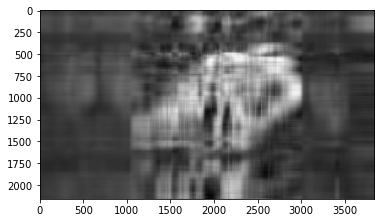

In [9]:
#imagem com os 7 maiores valores singulares
img_rank_7 = np.zeros((m, n))
for i in range(7):
 img_rank_7 = s[i]*u[:,i].reshape((-1,1)) @ vt[i,:].reshape((1,-1)) + img_rank_7
plt.imshow(img_rank_7, cmap=plt.get_cmap('gray'))
plt.show()

Porém a imagem ainda não está boa. Vamos usar 15 valores singulares.

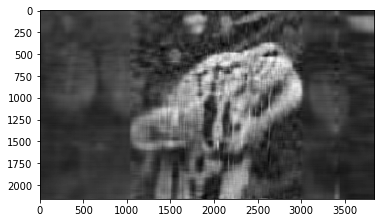

In [15]:
#hide_input
img_rank_15 = np.zeros((m, n))
for i in range(15):
 img_rank_15 = s[i]*u[:,i].reshape((-1,1)) @ vt[i,:].reshape((1,-1)) + img_rank_15
plt.imshow(img_rank_15, cmap=plt.get_cmap('gray'))
plt.show()

Dessa forma a imagem se torna entendível, mas vamos usar mais alguns valores singulares para deixá-la mais bonita.

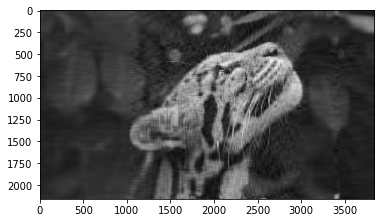

In [16]:
#imagem com os 30 maiores valores singulares
img_rank_30 = np.zeros((m, n))
for i in range(30):
 img_rank_30 = s[i]*u[:,i].reshape((-1,1)) @ vt[i,:].reshape((1,-1)) + img_rank_30
plt.imshow(img_rank_25, cmap=plt.get_cmap('gray'))
plt.show()

Dessa forma reconstruimos a imagem original de maneira razoavelmente boa. Mas em vez de usarmos 8.294.400 bytes agora usamos 30*2160 + 30 + 30*3840 = 180.030 bytes. Isso significa que temos um arquivo 46 vezes menor!